# 神经网络

神经网络的典型训练过程如下：
*   加载数据集，这里使用`torchvision`加载并标准化 MNIST 训练和测试数据集
*   定义具有一些可学习参数（或权重）的神经网络
*   遍历输入数据集
*   通过网络处理输入
*   计算损失（输出正确的距离有多远）
*   将梯度传播回网络参数
*   通常使用简单的更新规则来更新网络的权重：`weight = weight - learning_rate * gradient`
*   在测试数据上测试网络

## 数据加载

通常，当处理图像、文本、音频或视频数据时，先用第三方包如OpenCV将数据加载为 NumPy 数组，再将该数组转换为`torch.*Tensor`。

针对视觉，pytorch创建了一个名为`torchvision`的包，其中包含用于常见数据集（例如 Imagenet，CIFAR10，MNIST 等）的数据加载器，以及用于图像（即`torchvision.datasets`和`torch.utils.data.DataLoader`）的数据转换器。


### 1.加载并标准化 MNIST

使用`torchvision`，加载 MNIST 非常容易。

0.3%

100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

samples label :     1     0     6     4


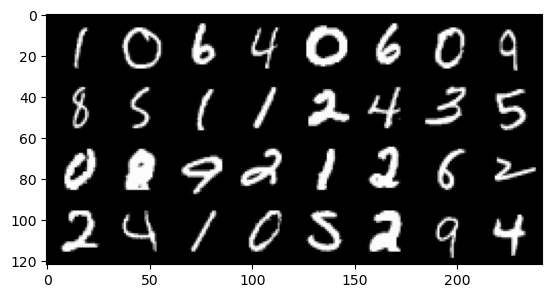

In [1]:
# conda install pytorch==1.12.0 torchvision==0.13.0 cpuonly -c pytorch
# 不指定版本可能会出现torchvision与pillow版本不兼容报错， https://stackoverflow.com/questions/59659146/could-not-import-pillow-version-from-pil
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 32
transform=transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))   
    ])

train_data = torchvision.datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
test_data = torchvision.datasets.MNIST('../data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


# conda install -c conda-forge matplotlib
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 打印前4个标签
print( 'samples label : '+ ' '.join('%5s' % classes[labels[j]] for j in range(4)))  
# show images
imshow(torchvision.utils.make_grid(images))

### 2.定义卷积神经网络

使用`torch.nn`包构建神经网络，首先定一个模型类，该类继承nn.Module类，在_init_方法中定义层，在forward方法中实现层的连接，下面以LeNet为例：

只需要定义`forward`函数，就可以使用`autograd`自动定义`backward`函数（计算梯度），可以在`forward`函数中使用任何张量操作。

关于模型定义详细说明参见[BUILD THE NEURAL NETWORK](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Avg pooling over a (2, 2) window
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.avg_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

#尝试一个32x32随机输入
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
tensor([[-0.0047, -0.0765, -0.0585, -0.0724,  0.0298, -0.0739, -0.0243,  0.1039,
          0.0886,  0.1403]], grad_fn=<AddmmBackward0>)



### 3.定义损失函数和优化器

`nn`包下有几种不同的[损失函数](https://pytorch.org/docs/nn.html#loss-functions)。 一个简单的损失是：`nn.MSELoss`，它计算输入和目标之间的均方误差。

当调用`loss.backward()`时，整个计算图将被微分。计算图中具有`requires_grad=True`的所有张量将随梯度累积其`.grad`张量。

实践中使用的最简单的更新规则是随机梯度下降（SGD），更新公式如下：

`weight = weight - learning_rate * gradient`

除了SGD，优化算法即优化器还有Nesterov-SGD，Adam，RMSProp等， 封装在`torch.optim`。

这里我们选择分类交叉熵损失和带有动量的 SGD。

In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)  # momentum 

### 4.训练网络

只需要遍历数据迭代器，然后将输入馈送到网络并进行优化即可。

In [4]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   # 参数自动更新
        
        pred = outputs.argmax(dim=1)  # outputs输出是（32,10）,取dim=1中最大的，输出32个最有可能匹配的类型
        num_correct += torch.eq(pred, labels).sum().int().item()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.5f， acc:%.5f' %
                  (epoch + 1, i + 1, running_loss / 500, num_correct/(500*batch_size)))
            running_loss = 0.0
            num_correct = 0

print('Finished Training')

PATH = './mnist_lenet.pth'
torch.save(net.state_dict(), PATH)

[1,   500] loss: 2.30155， acc:0.10981
[1,  1000] loss: 2.29213， acc:0.14550
[1,  1500] loss: 2.13032， acc:0.39819
[2,   500] loss: 0.50709， acc:0.84575
[2,  1000] loss: 0.38982， acc:0.88125
[2,  1500] loss: 0.34018， acc:0.89563
Finished Training


有关保存 PyTorch 模型的更多详细信息，请参见[此处](https://pytorch.org/docs/stable/notes/serialization.html)。

### 5.根据测试数据测试网络

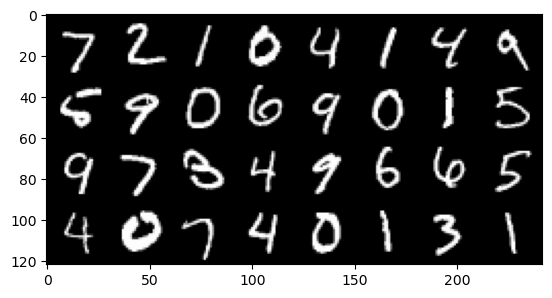

GroundTruth:      7     2     1     0
tensor([-0.2935, -6.0003,  0.4897,  2.7521, -2.8405, -0.4005, -6.8497,  9.5105,
         0.0675,  3.6680], grad_fn=<SelectBackward0>)
Predicted:      7     2     1     0
Accuracy of the network on the 10000 test images: 92 %
Accuracy of     0 : 97 %
Accuracy of     1 : 98 %
Accuracy of     2 : 90 %
Accuracy of     3 : 89 %
Accuracy of     4 : 89 %
Accuracy of     5 : 84 %
Accuracy of     6 : 94 %
Accuracy of     7 : 89 %
Accuracy of     8 : 93 %
Accuracy of     9 : 87 %


In [5]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


#可以重新加载保存的模型进行测试
# net = Net()
# net.load_state_dict(torch.load(PATH))
outputs = net(images)
unnorm_result = outputs[0]
print(unnorm_result)
#@TODO，要求unnorm_result中的数据归一化

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# 网络在整个数据集上的表现。

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

主要参考：<https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py>